# Chapter4 畳み込みニューラルネットワークを学ぶ　～画像分類プログラムを作る～
## 4. 画像の高解像度化

In [1]:
# 必要なパッケージのインストール
!pip3 install torch==1.6.0+cu101
!pip3 install torchvision==0.7.0+cu101
!pip3 install numpy==1.18.5
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.11.0
!pip3 install scikit-image

     |████████████████████████████████| 6.9MB 2.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## 4.2. 画像データの準備（Labeled Faces in the Wild）

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar -xzf lfw-deepfunneled.tgz
!ls lfw-deepfunneled/* |head -n 8

--2020-10-09 08:42:54--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz.1’

lfw-deepfunneled.tg 100%[===================>] 103.72M  14.3MB/s    in 12s     

2020-10-09 08:43:06 (8.73 MB/s) - ‘lfw-deepfunneled.tgz.1’ saved [108761145/108761145]

lfw-deepfunneled/Aaron_Eckhart:
Aaron_Eckhart_0001.jpg

lfw-deepfunneled/Aaron_Guiel:
Aaron_Guiel_0001.jpg

lfw-deepfunneled/Aaron_Patterson:
Aaron_Patterson_0001.jpg


## 4.3. 前準備（パッケージのインポート）

In [ ]:
# パッケージのインポート
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import math
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
from skimage.metrics import peak_signal_noise_ratio, structural_similarity 

## 4.4. 訓練データとテストデータの用意

In [ ]:
# データセットの作成
from PIL import Image
class DownsampleDataset(torch.utils.data.Dataset):
  def __init__(self, root, transform=None, highreso_size=128, lowreso_size=32):
    self.transform = transform

    self.highreso_resize = transforms.Resize(highreso_size)  # 高解像度
    self.lowreso_resize = transforms.Resize(lowreso_size)  # 低解像度

    self.image_paths = sorted(glob.glob(os.path.join(root + '/*/*jpg')))  # 画像パスのリスト取得
    self.images_n = len(self.image_paths)

  def __len__(self):
    return self.images_n  # 画像数のカウント

  def __getitem__(self, index):
    path = self.image_paths[index]  # indexをもとに画像のファイルパスを取得
    image = Image.open(path)  # 画像読み込み

    # 画像のリサイズ
    highreso_image = self.highreso_resize(image)  # 高解像度画像
    lowreso_image = self.highreso_resize(self.lowreso_resize(image))  # 低解像度画像。一度低解像度にしてから高解像度と同じ画像サイズに変換

    # transformが引数で与えられた場合
    if self.transform:
      highreso_image = self.transform(highreso_image)
      lowreso_image = self.transform(lowreso_image)

    return highreso_image, lowreso_image

In [ ]:
# 画像前処理の設定
transform=transforms.Compose([transforms.ToTensor(),  # Tensorに変換
                              transforms.Normalize(
                                  [0.5, 0.5, 0.5],  # RGBの平均
                                  [0.5, 0.5, 0.5],  # RGBの標準偏差
                                  )])

dataset size: 13233


In [ ]:
# データセットの作成を実行
dataset = DownsampleDataset('lfw-deepfunneled', transform=transform, highreso_size=128, lowreso_size=32)

print("dataset size: {}".format(len(dataset)))

In [ ]:
# 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

print("train_dataset size: {}".format(len(train_dataset)))
print("test_dataset size: {}".format(len(test_dataset)))

train_dataset size: 10586
test_dataset size: 2647


In [ ]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = torch.utils.data.DataLoader(dataset=train_dataset,  # 対象となるデータセット
                                          batch_size=64,  # バッチサイズ
                                          shuffle=True,  # 画像のシャッフル
                                          num_workers=2)  # 並列処理数
test_batch = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=64,
                                         shuffle=False,
                                         num_workers=2)

# ミニバッチデータセットの確認
for highreso_images, lowreso_images in train_batch:
    print("batch highreso_images size: {}".format(highreso_images.size()))  # 高解像度画像バッチのサイズ
    print("highreso image size: {}".format(highreso_images[0].size()))  # 1枚の高解像度画像サイズ
    print("batch lowreso_images size: {}".format(lowreso_images.size()))  # 低解像度画像バッチのサイズ
    print("lowreso image size: {}".format(lowreso_images[1].size()))  # 1枚の低解像度画像サイズ
    break

batch highreso_images size: torch.Size([64, 3, 128, 128])
highreso image size: torch.Size([3, 128, 128])
batch lowreso_images size: torch.Size([64, 3, 128, 128])
lowreso image size: torch.Size([3, 128, 128])


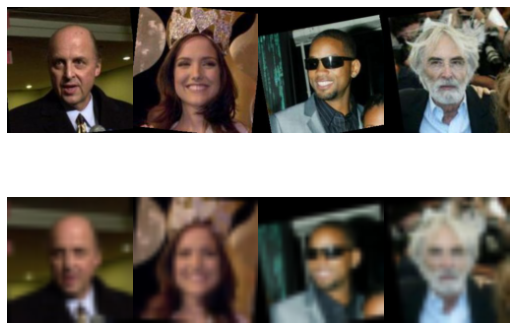

In [ ]:
# 画像の表示
def cat_imshow(x, y, images1, images2, images3=None):
  plt.figure(figsize=(9, 7))
  for i in range(x*y):  # X * Y枚の画像を表示
    if i <= 3:
      images = images1
      image = images[i] / 2 + 0.5  # 標準化を解除
    elif i > 3 and i <= 7:
      images = images2
      image = images[i-4] / 2 + 0.5
    elif images3 != None: 
      images = images3
      image = images[i-8] / 2 + 0.5
    
    image = image.numpy()  # Tensorからndarrayへ
    plt.subplot(x, y, i+1)  # X x Yとなるように格子状にプロット
    plt.imshow(np.transpose(image, (1, 2, 0)))  # matplotlibでは(縦, 横, チャネル)の順
    plt.axis('off')  # 目盛を消去
    plt.subplots_adjust(wspace=0, hspace=0)  # 画像間の余白の設定
  plt.show()  # 表示

# 画像の確認
for highreso_images, lowreso_images in train_batch:
  cat_imshow(2, 4, highreso_images, lowreso_images)  # 画像の表示
  break

## 4.5. ニューラルネットワークの定義

In [ ]:
# ニューラルネットワークの定義
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x


# ネットワークのロード
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = SRCNN().to(device)
print(net)
# デバイスの確認
print("Device: {}".format(device))

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)
Device: cuda


## 4.6. 損失関数と最適化関数の定義

In [ ]:
# 損失関数の定義
criterion = nn.MSELoss()

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

In [ ]:
# 画像評価指標の計算
def cal_psnr_ssim(img1, img2, data_range=1):
  dim = len(img1.size()) # 画像の次元数を確認
  img1 = img1.to('cpu').detach().numpy()  # Tensorからndarrayに変換
  img2 = img2.to('cpu').detach().numpy()

  # 画像が1枚だけの場合
  if dim == 3:
    # (チャネル, 縦, 横)から(縦, 横, チャネル)の順になるよう並び替え
    img1 = np.transpose(img1, (1, 2, 0))  
    img2 = np.transpose(img2, (1, 2, 0))
    psnr = peak_signal_noise_ratio(img1, img2, data_range=data_range)  # PSNR
    ssim = structural_similarity(img1, img2, multichannel=True, data_range=data_range)  # SSIM
    return psnr, ssim
  
  # 画像がバッチで渡された場合
  else:
    img1 = np.transpose(img1, (0, 2, 3, 1))  
    img2 = np.transpose(img2, (0, 2, 3, 1))
    # 初期化
    all_psnr = 0
    all_ssim = 0
    n_batchs = img1.shape[0]
    for i in range(n_batchs):
      psnr = peak_signal_noise_ratio(img1[i], img2[i], data_range=data_range)  # PSNR
      ssim = structural_similarity(img1[i], img2[i], data_range=data_range, multichannel=True)  # SSIM
      all_psnr += psnr
      all_ssim += ssim

    mean_psnr = all_psnr / n_batchs
    mean_ssim = all_ssim / n_batchs
    return mean_psnr, mean_ssim

In [ ]:
for highreso_images, lowreso_images in train_batch:
  psnr, ssim = cal_psnr_ssim(highreso_images[0], lowreso_images[0], data_range=1)  # 画像1枚だけ入力
  batch_psnr, batch_ssim = cal_psnr_ssim(highreso_images, lowreso_images, data_range=1)  # 画像バッチで入力
  print("SINGLE PSNR: {:.4f}, SSIM: {:.4f}".format(psnr, ssim))
  print("BATCH  PSNR: {:.4f}, SSIM: {:.4f}".format(batch_psnr, batch_ssim))
  break

SINGLE PSNR: 18.8616, SSIM: 0.6658
BATCH  PSNR: 17.7824, SSIM: 0.6695


## 4.7. 学習

In [ ]:
# 損失を保存するリストを作成
train_loss_list = []  # 学習損失（MSE）
test_loss_list = []  # 評価損失（MSE）
train_psnr_list = []  # 学習PSNR
test_psnr_list = []  # 評価PSNR
train_ssim_list = []  # 学習SSIM
test_ssim_list = []  # 評価SSIM

# 学習（エポック）の実行
epoch = 100  # 学習回数: 100
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失の初期化
    train_loss = 0  # 学習損失（MSE）
    test_loss = 0  # 評価損失（MSE）
    train_psnr = 0  # 学習PSNR
    test_psnr = 0  # 評価PSNR
    train_ssim = 0  # 学習SSIM
    test_ssim = 0  # 評価SSIM

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    i = 0
    for highreso_images, lowreso_images in train_batch:
        # GPUにTensorを転送
        highreso_images = highreso_images.to(device)  # 高解像度画像
        lowreso_images = lowreso_images.to(device)  # 低解像度画像


        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred = net(lowreso_images)
        # 損失（誤差）を計算
        loss = criterion(y_pred, highreso_images)  # MSE
        psnr, ssim = cal_psnr_ssim(y_pred, highreso_images)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()
        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()  # MSE
        train_psnr += psnr  # PSNR
        train_ssim += ssim  # SSIM
        i += 1


    # ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_batch)  # 損失(MSE)
    batch_train_psnr = train_psnr / len(train_batch)  # PSNR
    batch_train_ssim = train_ssim / len(train_batch)  # SSIM
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for highreso_images, lowreso_images in test_batch:
            # GPUにTensorを転送
            highreso_images = highreso_images.to(device)
            lowreso_images = lowreso_images.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred = net(lowreso_images)
            # 損失（誤差）を計算
            loss = criterion(y_pred, highreso_images)  # MSE
            psnr, ssim = cal_psnr_ssim(y_pred, highreso_images)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()  # MSE
            test_psnr += psnr  # PSNR
            test_ssim += ssim  # SSIM

    # ミニバッチの平均の損失を計算
    batch_test_loss = test_loss / len(test_batch)  # 損失(MSE)
    batch_test_psnr = test_psnr / len(test_batch)  # PSNR
    batch_test_ssim = test_ssim / len(test_batch)  # SSIM
    # ---------評価パートはここまで--------- #

    # エポックごとに損失を表示
    print("Train_Loss: {:.4f} Train_PSNR: {:.4f}  Train_SSIM: {:.4f}".format(
        batch_train_loss, batch_train_psnr, batch_train_ssim))
    print("Test_Loss: {:.4f} Test_PSNR: {:.4f}  Test_SSIM: {:.4f}".format(
        batch_test_loss, batch_test_psnr, batch_test_ssim))
    # 損失をリスト化して保存
    train_loss_list.append(batch_train_loss)  # 訓練損失リスト
    test_loss_list.append(batch_test_loss)  # テスト訓練リスト
    train_psnr_list.append(batch_train_psnr)  # 訓練PSNR
    test_psnr_list.append(batch_test_psnr)  # テストPSNR
    train_ssim_list.append(batch_train_ssim)  # 訓練SSIM
    test_ssim_list.append(batch_test_ssim)  # テストSSIM

---------------------------------------------
Epoch: 1/100
Train_Loss: 0.0354 Train_PSNR: 15.9054  Train_SSIM: 0.5735
Test_Loss: 0.0157 Test_PSNR: 18.3575  Test_SSIM: 0.6841
---------------------------------------------
Epoch: 2/100
Train_Loss: 0.0137 Train_PSNR: 18.9619  Train_SSIM: 0.7139
Test_Loss: 0.0127 Test_PSNR: 19.3110  Test_SSIM: 0.7295
---------------------------------------------
Epoch: 3/100
Train_Loss: 0.0121 Train_PSNR: 19.5295  Train_SSIM: 0.7417
Test_Loss: 0.0117 Test_PSNR: 19.6882  Test_SSIM: 0.7480
---------------------------------------------
Epoch: 4/100
Train_Loss: 0.0113 Train_PSNR: 19.8194  Train_SSIM: 0.7526
Test_Loss: 0.0115 Test_PSNR: 19.7332  Test_SSIM: 0.7550
---------------------------------------------
Epoch: 5/100
Train_Loss: 0.0109 Train_PSNR: 19.9584  Train_SSIM: 0.7579
Test_Loss: 0.0108 Test_PSNR: 20.0473  Test_SSIM: 0.7613
---------------------------------------------
Epoch: 6/100
Train_Loss: 0.0105 Train_PSNR: 20.1644  Train_SSIM: 0.7642
Test_Loss: 0

## 4.8. 結果の可視化

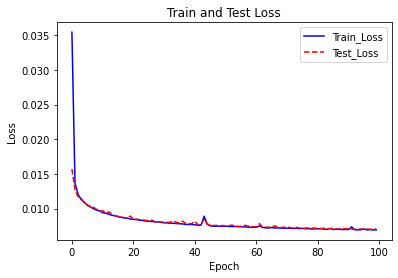

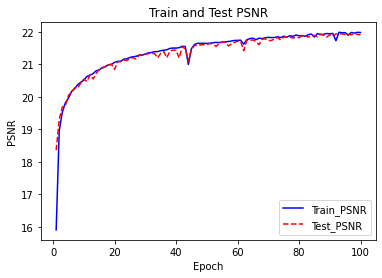

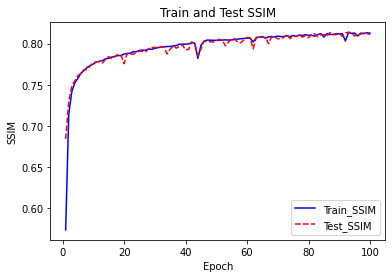

In [ ]:
# 損失（MSE）
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()  # 凡例

# PSNR
plt.figure()
plt.title('Train and Test PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.plot(range(1, epoch+1), train_psnr_list, color='blue',
         linestyle='-', label='Train_PSNR')
plt.plot(range(1, epoch+1), test_psnr_list, color='red',
         linestyle='--', label='Test_PSNR')
plt.legend()  # 凡例

# SSIM
plt.figure()
plt.title('Train and Test SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.plot(range(1, epoch+1), train_ssim_list, color='blue',
         linestyle='-', label='Train_SSIM')
plt.plot(range(1, epoch+1), test_ssim_list, color='red',
         linestyle='--', label='Test_SSIM')
plt.legend()  # 凡例

# 表示
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Lowreso vs Highreso, PSNR: 17.0765, SSIM: 0.6631
DL_recon vs Highreso, PSNR: 21.6480, SSIM: 0.8150


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


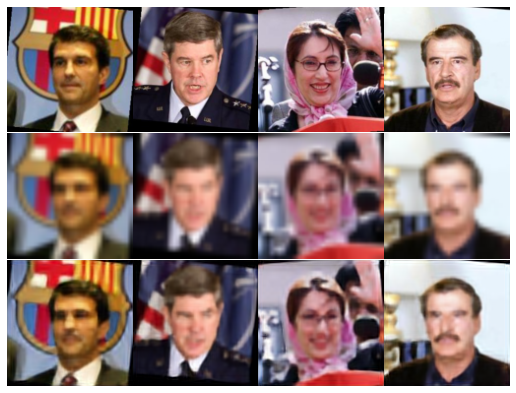

In [ ]:
# 再構成した画像の確認
# ニューラルネットワークを評価モードに設定
net.eval()
# 推定時の計算で自動微分機能をオフにする
with torch.no_grad():
    for highreso_images, lowreso_images in test_batch:
        # GPUにTensorを転送
        highreso_images = highreso_images.to(device)
        lowreso_images = lowreso_images.to(device)
        # データを入力して予測値を計算（順伝播）
        y_pred = net(lowreso_images)
        # 画質評価
        psnr1, ssim1 = cal_psnr_ssim(lowreso_images, highreso_images)  # 低解像度 vs 高解像度
        psnr2, ssim2 = cal_psnr_ssim(y_pred, highreso_images)  # ディープラーニング再構成 vs 高解像度
        print("Lowreso vs Highreso, PSNR: {:.4f}, SSIM: {:.4f}".format(psnr1, ssim1))
        print("DL_recon vs Highreso, PSNR: {:.4f}, SSIM: {:.4f}".format(psnr2, ssim2))
        
        # 画像表示
        cat_imshow(3, 4, highreso_images.to('cpu'), lowreso_images.to('cpu'), y_pred.to('cpu'))
        plt.show()  # 表示
        break